## 속도비교

In [1]:
!pip -q install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 74.5 MB/s eta 0:00:00


In [20]:
import os, time, math, random, requests
from io import BytesIO
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torchvision
from torchvision.transforms import functional as F
from ultralytics import YOLO

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


## (과제) 모델 불러오기: 빈칸 채우기

코드 사이의 빈칸을 채워가면서, 아래 두 질문에 답해주세요

(gpt 안 쓰고 풀면 도움 많이 될 거야..)


In [22]:
# Faster R-CNN (torchvision)
frcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
).to(device).eval()

# YOLO (ultralytics) - YOLOv8n
yolo = YOLO("yolov8n.pt")  # 작은 모델이라 속도 비교에 좋음

In [23]:
urls = [
    "https://ultralytics.com/images/bus.jpg",
    "https://ultralytics.com/images/zidane.jpg"
]

pil_imgs = []
for url in urls:
    img = Image.open(BytesIO(requests.get(url).content)).convert("RGB")
    pil_imgs.append(img)

len(pil_imgs), pil_imgs[0]

(2, <PIL.Image.Image image mode=RGB size=810x1080>)

In [24]:
def resize_pil(img: Image.Image, size: int) -> Image.Image:
    """Speed benchmark용: 비율 유지 없이 (size, size)로 리사이즈"""
    return img.resize((size, size), Image.BILINEAR)

@torch.no_grad()
def time_faster_rcnn(model, pil_imgs, size: int, warmup: int = 5, runs: int = 30):
    """torchvision Faster R-CNN: ms/img, FPS 측정"""
    batch_cpu = [F.to_tensor(resize_pil(im, size)).to(device) for im in pil_imgs]

    # Warmsup
    for _ in range(warmup):
        batch = [x.to(device, non_blocking=True) for x in batch_cpu]
        _ = model(batch)
    if device == "cuda":
        torch.cuda.synchronize()

    # runs
    t0 = time.perf_counter()
    for _ in range(runs):
        batch = [x.to(device, non_blocking=True) for x in batch_cpu]
        _ = model(batch)
    if device == "cuda":
        torch.cuda.synchronize()
    t1 = time.perf_counter()

    total = (t1 - t0)
    n_imgs = runs * len(batch)
    sec_per_img = total / n_imgs
    ms_per_img = sec_per_img * 1000
    fps = 1.0 / sec_per_img
    return ms_per_img, fps

@torch.no_grad()
def time_yolo(model, pil_imgs, size: int, warmup: int = 5, runs: int = 30, conf: float = 0.25, iou: float = 0.7):
    """ultralytics YOLO: ms/img, FPS 측정 (predict 포함)"""
    imgs = [np.array(resize_pil(im, size)) for im in pil_imgs]

    # warmup
    for _ in range(warmup):
        _ = model.predict(imgs, imgsz=size, conf=conf, iou=iou, verbose=False)
    if device == "cuda":
        torch.cuda.synchronize()

    # runs
    t0 = time.perf_counter()
    for _ in range(runs):
        _ = model.predict(imgs, imgsz=size, conf=conf, iou=iou, verbose=False)
    if device == "cuda":
        torch.cuda.synchronize()
    t1 = time.perf_counter()

    total = (t1 - t0)
    n_imgs = runs * len(imgs)
    sec_per_img = total / n_imgs
    ms_per_img = sec_per_img * 1000
    fps = 1.0 / sec_per_img
    return ms_per_img, fps

def benchmark(models: dict, pil_imgs, sizes=(416, 608), runs: int = 30, warmup: int = 5):
    """
    models: {'name': ('frcnn'|'yolo', model)}
    반환: df (Model, Input Size, ms/img, FPS(img/s))
    """
    rows = []
    for s in sizes:
        for name, (mtype, model) in models.items():
            if mtype == "frcnn":
                ms, fps = time_faster_rcnn(model, pil_imgs, size=s, warmup=warmup, runs=runs)
            elif mtype == "yolo":
                ms, fps = time_yolo(model, pil_imgs, size=s, warmup=warmup, runs=runs)
            else:
                raise ValueError(f"Unknown model type: {mtype}")

            rows.append({"Model": name, "Input Size": f"{s}x{s}", "ms/img": ms, "FPS(img/s)": fps})

    return pd.DataFrame(rows)

In [25]:
# 해상도별 속도 비교 설정
sizes = [416, 608]
runs = 30            # 측정 반복 횟수
warmup = 5

models = {
    "Faster R-CNN (R50-FPN)": ("frcnn", frcnn),
    "YOLO": ("yolo", yolo),
}

df = benchmark(models, pil_imgs, sizes=sizes, runs=runs, warmup=warmup)
df


,Model,Input Size,ms/img,FPS(img/s)
0,Faster R-CNN (R50-FPN),416x416,85.924843,11.638078
1,YOLO,416x416,4.268945,234.249937
2,Faster R-CNN (R50-FPN),608x608,87.073353,11.484570
3,YOLO,608x608,5.398741,185.228387


In [26]:
# FPS 비교 표 (모델 x 해상도)
fps_table = df.pivot(index="Model", columns="Input Size", values="FPS(img/s)").round(2)
ms_table  = df.pivot(index="Model", columns="Input Size", values="ms/img").round(2)

display(fps_table)
display(ms_table)


Input Size,416x416,608x608
Model,,
Faster R-CNN (R50-FPN),11.64,11.48
YOLO,234.25,185.23


Input Size,416x416,608x608
Model,,
Faster R-CNN (R50-FPN),85.92,87.07
YOLO,4.27,5.40


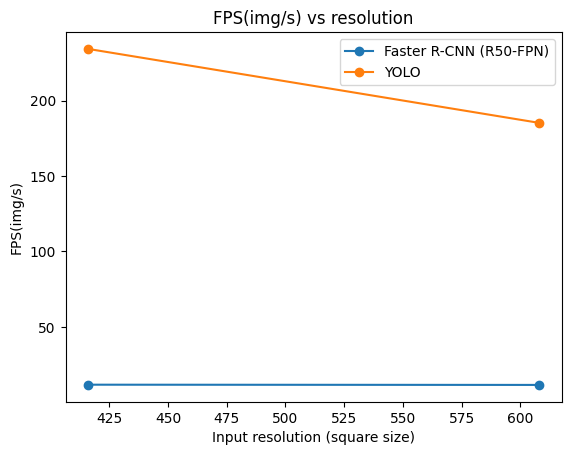

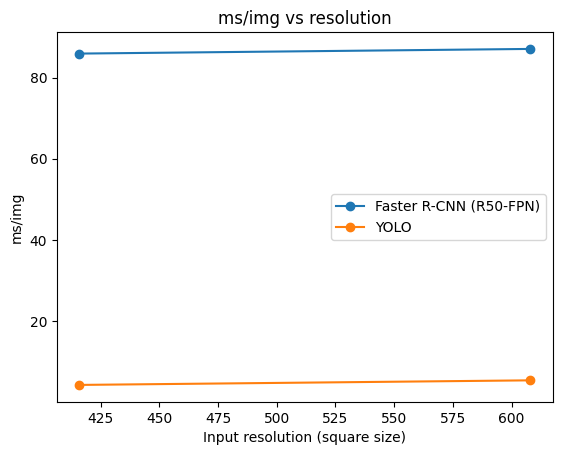

In [27]:
# 시각화

import matplotlib.pyplot as plt

df_plot = df.copy()
df_plot["Size"] = df_plot["Input Size"].str.split("x").str[0].astype(int)

for metric in ["FPS(img/s)", "ms/img"]:
    plt.figure()
    for m in df_plot["Model"].unique():
        sub = df_plot[df_plot["Model"] == m].sort_values("Size")
        plt.plot(sub["Size"], sub[metric], marker="o", label=m)
    plt.xlabel("Input resolution (square size)")
    plt.ylabel(metric)
    plt.title(f"{metric} vs resolution")
    plt.legend()
    plt.show()


## 결과 비교

In [28]:
os.makedirs("vis", exist_ok=True)


In [29]:
from PIL import Image, ImageDraw, ImageFont

def draw_boxes_pil(
    img: Image.Image,
    boxes,        # Tensor or list로 표시
    scores=None,
    labels=None,
    score_thr=0.5
):
    draw = ImageDraw.Draw(img)

    for i, box in enumerate(boxes):
        if scores is not None and scores[i] < score_thr:
            continue

        x1, y1, x2, y2 = '''___빈칸을_채워주세요___''' # ← 좌표 처리

        draw.rectangle(
            [(x1, y1), (x2, y2)],
            outline= '''___빈칸을_채워주세요___''',   # 색 지정
            width='''___빈칸을_채워주세요___'''       # 선 두께
        )

        if labels is not None:
            text = '''___빈칸을_채워주세요___'''      # label + score
            draw.text(
                (x1, y1),
                text,
                fill= '''___빈칸을_채워주세요___''' # 색
            )

    return img

In [18]:
@torch.no_grad()
def run_frcnn_and_draw(model, pil_img, size=416):
    img_rs = resize_pil(pil_img, size)
    x = F.to_tensor(img_rs).to(device)

    pred = model([x])[0]
    boxes  = pred["boxes"].cpu().numpy()
    scores = pred["scores"].cpu().numpy()
    labels = pred["labels"].cpu().numpy()

    label_names = [
        torchvision.models.detection
        .FasterRCNN_ResNet50_FPN_Weights
        .DEFAULT.meta["categories"][l]
        for l in labels
    ]

    vis = draw_boxes_pil(
        img_rs,
        boxes,
        scores=scores,
        labels=label_names,
        score_thr=0.5
    )
    return vis


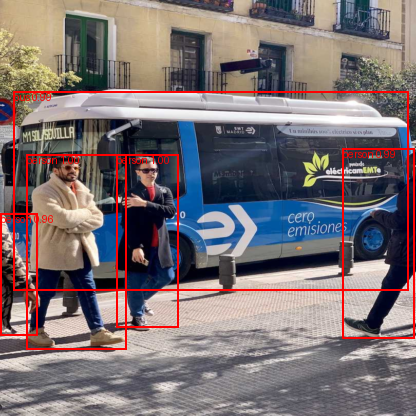

In [19]:
#아래 결과가 나오면 됩니다!!

run_frcnn_and_draw(frcnn, pil_imgs[0], size=416)

# 문제문제

### Q1.
위에서 나온 결과표를 바탕으로, Faster R-CNN과 YOLO 속도 차이를 요약해보세요. 이때 해상도가 증가할수록 두 모델의 속도가 어떻게 변하는지도 설명해주세요.

Ans. '''**여기에 작성해주세요**'''

### Q2.
결과를 확인해보면 Faster R-CNN과 YOLO는 해상도 변화에 따라 받아들이는 정도가 다릅니다. 그 이유에 대해 모델 구조/전처리 관점에서 2가지 가설을 세워보세요.

Ans. '''**여기에 작성해주세요**'''